In [9]:
import torch
from torch import nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

import matplotlib
# matplotlib.use('Agg')
%matplotlib inline

import datetime as dt, itertools, pandas as pd, matplotlib.pyplot as plt, numpy as np

import utility as util

global logger

util.setup_log()
# util.setup_path()
logger = util.logger


In [5]:
class encoder(nn.Module):
    def __init__(self, input_size, hidden_size, T, logger):
        # input size: number of underlying factors (81)
        # T: number of time steps (10)
        # hidden_size: dimension of the hidden state
        super(encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.T = T

        self.logger = logger

        self.lstm_layer = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = 1)
        self.attn_linear = nn.Linear(in_features = 2 * hidden_size + T - 1, out_features = 1)

    def forward(self, input_data):
        # input_data: batch_size * T - 1 * input_size        
        input_weighted = Variable(input_data.data.new(input_data.size(0), self.T - 1, self.input_size).zero_())
        input_encoded = Variable(input_data.data.new(input_data.size(0), self.T - 1, self.hidden_size).zero_())
        # hidden, cell: initial states with dimention hidden_size
        hidden = self.init_hidden(input_data) # 1 * batch_size * hidden_size
        cell = self.init_hidden(input_data)
        # hidden.requires_grad = False
        # cell.requires_grad = False
        for t in range(self.T - 1):
            # Eqn. 8: concatenate the hidden states with each predictor
            x = torch.cat((hidden.repeat(self.input_size, 1, 1).permute(1, 0, 2),
                           cell.repeat(self.input_size, 1, 1).permute(1, 0, 2),
                           input_data.permute(0, 2, 1)), dim = 2) # batch_size * input_size * (2*hidden_size + T - 1)
            # Eqn. 9: Get attention weights
            x = self.attn_linear(x.view(-1, self.hidden_size * 2 + self.T - 1)) # (batch_size * input_size) * 1
            attn_weights = F.softmax(x.view(-1, self.input_size)) # batch_size * input_size, attn weights with values sum up to 1.
            # Eqn. 10: LSTM
            weighted_input = torch.mul(attn_weights, input_data[:, t, :]) # batch_size * input_size
            # Fix the warning about non-contiguous memory
            # see https://discuss.pytorch.org/t/dataparallel-issue-with-flatten-parameter/8282
            self.lstm_layer.flatten_parameters()
            _, lstm_states = self.lstm_layer(weighted_input.unsqueeze(0), (hidden, cell))
            hidden = lstm_states[0]
            cell = lstm_states[1]
            # Save output
            input_weighted[:, t, :] = weighted_input
            input_encoded[:, t, :] = hidden
        return input_weighted, input_encoded

    def init_hidden(self, x):
        # No matter whether CUDA is used, the returned variable will have the same type as x.
        return Variable(x.data.new(1, x.size(0), self.hidden_size).zero_()) # dimension 0 is the batch dimension

class decoder(nn.Module):
    def __init__(self, encoder_hidden_size, decoder_hidden_size, T, logger):
        super(decoder, self).__init__()

        self.T = T
        self.encoder_hidden_size = encoder_hidden_size
        self.decoder_hidden_size = decoder_hidden_size

        self.logger = logger

        self.attn_layer = nn.Sequential(nn.Linear(2 * decoder_hidden_size + encoder_hidden_size, encoder_hidden_size),
                                         nn.Tanh(), nn.Linear(encoder_hidden_size, 1))
        self.lstm_layer = nn.LSTM(input_size = 1, hidden_size = decoder_hidden_size)
        self.fc = nn.Linear(encoder_hidden_size + 1, 1)
        self.fc_final = nn.Linear(decoder_hidden_size + encoder_hidden_size, 1)

        self.fc.weight.data.normal_()

    def forward(self, input_encoded, y_history):
        # input_encoded: batch_size * T - 1 * encoder_hidden_size
        # y_history: batch_size * (T-1)
        # Initialize hidden and cell, 1 * batch_size * decoder_hidden_size
        hidden = self.init_hidden(input_encoded)
        cell = self.init_hidden(input_encoded)
        # hidden.requires_grad = False
        # cell.requires_grad = False
        for t in range(self.T - 1):
            # Eqn. 12-13: compute attention weights
            ## batch_size * T * (2*decoder_hidden_size + encoder_hidden_size)
            x = torch.cat((hidden.repeat(self.T - 1, 1, 1).permute(1, 0, 2),
                           cell.repeat(self.T - 1, 1, 1).permute(1, 0, 2), input_encoded), dim = 2)
            x = F.softmax(self.attn_layer(x.view(-1, 2 * self.decoder_hidden_size + self.encoder_hidden_size
                                                )).view(-1, self.T - 1)) # batch_size * T - 1, row sum up to 1
            # Eqn. 14: compute context vector
            context = torch.bmm(x.unsqueeze(1), input_encoded)[:, 0, :] # batch_size * encoder_hidden_size
            if t < self.T - 1:
                # Eqn. 15
                y_tilde = self.fc(torch.cat((context, y_history[:, t].unsqueeze(1)), dim = 1)) # batch_size * 1
                # Eqn. 16: LSTM
                self.lstm_layer.flatten_parameters()
                _, lstm_output = self.lstm_layer(y_tilde.unsqueeze(0), (hidden, cell))
                hidden = lstm_output[0] # 1 * batch_size * decoder_hidden_size
                cell = lstm_output[1] # 1 * batch_size * decoder_hidden_size
        # Eqn. 22: final output
        y_pred = self.fc_final(torch.cat((hidden[0], context), dim = 1))
        # self.logger.info("hidden %s context %s y_pred: %s", hidden[0][0][:10], context[0][:10], y_pred[:10])
        return y_pred

    def init_hidden(self, x):
        return Variable(x.data.new(1, x.size(0), self.decoder_hidden_size).zero_())

In [87]:
# Train the model
class da_rnn:
    def __init__(self, file_data, logger, encoder_hidden_size = 64, decoder_hidden_size = 64, T = 10,
                 learning_rate = 0.01, batch_size = 128, parallel = True, data_type='pm25', debug = True):
        self.T = T
        if data_type == "nasdaq":
            dat = pd.read_csv(file_data, nrows = 100 if debug else None)
            self.logger = logger
            self.logger.info("Shape of data: %s.\nMissing in data: %s.", dat.shape, dat.isnull().sum().sum())

            self.X = dat.loc[:, [x for x in dat.columns.tolist() if x != 'NDX']].as_matrix()
            self.y = np.array(dat.NDX)
        else:
            dat = pd.read_csv(file_data, nrows = 100 if debug else 5000)
            dat = dat.drop(dat.columns[0], axis=1)
            print(dat)
            self.logger = logger
            self.logger.info("Shape of data: %s.\nMissing in data: %s.", dat.shape, dat.isnull().sum().sum())

            self.X = dat.loc[:, [x for x in dat.columns.tolist() if x != 'pm25']].as_matrix()
            self.y = np.array(dat.pm25)
            
            
        self.batch_size = batch_size

        self.encoder = encoder(input_size = self.X.shape[1], hidden_size = encoder_hidden_size, T = T,
                              logger = logger)
        self.decoder = decoder(encoder_hidden_size = encoder_hidden_size,
                               decoder_hidden_size = decoder_hidden_size,
                               T = T, logger = logger)

        if parallel:
            self.encoder = nn.DataParallel(self.encoder)
            self.decoder = nn.DataParallel(self.decoder)

        self.encoder_optimizer = optim.Adam(params = filter(lambda p: p.requires_grad, self.encoder.parameters()),
                                           lr = learning_rate)
        self.decoder_optimizer = optim.Adam(params = filter(lambda p: p.requires_grad, self.decoder.parameters()),
                                           lr = learning_rate)
        # self.learning_rate = learning_rate

        self.train_size = int(self.X.shape[0] * 0.7)
        self.y = self.y - np.mean(self.y[:self.train_size]) # Question: why Adam requires data to be normalized?
        self.logger.info("Training size: %d.", self.train_size)

    def train(self, n_epochs = 10):
        iter_per_epoch = int(np.ceil(self.train_size * 1. / self.batch_size))
        logger.info("Iterations per epoch: %3.3f ~ %d.", self.train_size * 1. / self.batch_size, iter_per_epoch)
        self.iter_losses = np.zeros(n_epochs * iter_per_epoch)
        self.epoch_losses = np.zeros(n_epochs)

        self.loss_func = nn.MSELoss()

        n_iter = 0

        learning_rate = 1.

        for i in range(n_epochs):
            perm_idx = np.random.permutation(self.train_size - self.T)
            j = 0
            while j < self.train_size:
                batch_idx = perm_idx[j:(j + self.batch_size)]
                X = np.zeros((len(batch_idx), self.T - 1, self.X.shape[1]))
                y_history = np.zeros((len(batch_idx), self.T - 1))
                y_target = self.y[batch_idx + self.T]

                for k in range(len(batch_idx)):
                    X[k, :, :] = self.X[batch_idx[k] : (batch_idx[k] + self.T - 1), :]
                    y_history[k, :] = self.y[batch_idx[k] : (batch_idx[k] + self.T - 1)]

                loss = self.train_iteration(X, y_history, y_target)
                self.iter_losses[int(i * iter_per_epoch + j / self.batch_size)] = loss
                #if (j / self.batch_size) % 50 == 0:
                #    self.logger.info("Epoch %d, Batch %d: loss = %3.3f.", i, j / self.batch_size, loss)
                j += self.batch_size
                n_iter += 1

                if n_iter % 10000 == 0 and n_iter > 0:
                    for param_group in self.encoder_optimizer.param_groups:
                        param_group['lr'] = param_group['lr'] * 0.9
                    for param_group in self.decoder_optimizer.param_groups:
                        param_group['lr'] = param_group['lr'] * 0.9

            self.epoch_losses[i] = np.mean(self.iter_losses[range(i * iter_per_epoch, (i + 1) * iter_per_epoch)])
            if i % 10 == 0:
                self.logger.info("Epoch %d, loss: %3.3f.", i, self.epoch_losses[i])

            if i % 10 == 0:
                y_train_pred = self.predict(on_train = True)
                y_test_pred = self.predict(on_train = False)
                y_pred = np.concatenate((y_train_pred, y_test_pred))
                plt.figure()
                plt.plot(range(1, 1 + len(self.y)), self.y, label = "True")
                plt.plot(range(self.T , len(y_train_pred) + self.T), y_train_pred, label = 'Predicted - Train')
                plt.plot(range(self.T + len(y_train_pred) , len(self.y) + 1), y_test_pred, label = 'Predicted - Test')
                plt.legend(loc = 'upper left')
                plt.show()

    def train_iteration(self, X, y_history, y_target):
        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()

        input_weighted, input_encoded = self.encoder(Variable(torch.from_numpy(X).type(torch.FloatTensor)))
        y_pred = self.decoder(input_encoded, Variable(torch.from_numpy(y_history).type(torch.FloatTensor))).transpose(0,1)[0]

        y_true = Variable(torch.from_numpy(y_target).type(torch.FloatTensor))
#         logger.info("y_pred: %s", y_pred.shape)
#         logger.info("y_true: %s", y_true.shape)
        loss = self.loss_func(y_pred, y_true)
        loss.backward()

        self.encoder_optimizer.step()
        self.decoder_optimizer.step()

        return loss.data[0]

    def predict(self, on_train = False):
        if on_train:
            y_pred = np.zeros(self.train_size - self.T + 1)
        else:
            y_pred = np.zeros(self.X.shape[0] - self.train_size)

        i = 0
        while i < len(y_pred):
            batch_idx = np.array(range(len(y_pred)))[i : (i + self.batch_size)]
            X = np.zeros((len(batch_idx), self.T - 1, self.X.shape[1]))
            y_history = np.zeros((len(batch_idx), self.T - 1))
            for j in range(len(batch_idx)):
                if on_train:
                    X[j, :, :] = self.X[range(batch_idx[j], batch_idx[j] + self.T - 1), :]
                    y_history[j, :] = self.y[range(batch_idx[j],  batch_idx[j]+ self.T - 1)]
                else:
                    X[j, :, :] = self.X[range(batch_idx[j] + self.train_size - self.T, batch_idx[j] + self.train_size - 1), :]
                    y_history[j, :] = self.y[range(batch_idx[j] + self.train_size - self.T,  batch_idx[j]+ self.train_size - 1)]

            y_history = Variable(torch.from_numpy(y_history).type(torch.FloatTensor))
            _, input_encoded = self.encoder(Variable(torch.from_numpy(X).type(torch.FloatTensor)))
            y_pred[i:(i + self.batch_size)] = self.decoder(input_encoded, y_history).cpu().data.numpy()[:, 0]
            i += self.batch_size
        return y_pred

2018-05-05 00:35:23,228 - VOC_TOPICS - INFO - Shape of data: (40560, 82).
Missing in data: 0.
2018-05-05 00:35:23,228 - VOC_TOPICS - INFO - Shape of data: (40560, 82).
Missing in data: 0.
2018-05-05 00:35:23,264 - VOC_TOPICS - INFO - Training size: 28392.
2018-05-05 00:35:23,264 - VOC_TOPICS - INFO - Training size: 28392.
2018-05-05 00:35:23,266 - VOC_TOPICS - INFO - Iterations per epoch: 221.812 ~ 222.
2018-05-05 00:35:23,266 - VOC_TOPICS - INFO - Iterations per epoch: 221.812 ~ 222.


           AAL      AAPL      ADBE      ADI       ADP       ADSK     AKAM  \
0      35.9800   96.8000   97.8000  61.1500   95.4000  58.180000  58.0000   
1      35.9310   96.8900   97.8000  61.6100   95.4115  58.190000  58.1200   
2      35.9044   96.9500   97.5700  61.9800   95.5100  58.203333  57.9500   
3      35.8900   96.9700   97.5500  62.0900   95.5200  58.216667  57.9600   
4      36.0080   96.9600   97.7300  61.8900   95.5300  58.230000  58.2100   
5      36.1000   97.0450   97.8800  62.0900   95.7500  58.225000  58.2200   
6      36.0922   97.0950   97.9300  62.0700   95.7500  58.220000  58.3500   
7      36.0500   97.1450   97.9400  62.0400   95.7300  58.250000  58.3400   
8      36.0500   97.2300   98.0000  61.9900   95.6900  58.250000  58.3700   
9      36.1200   97.3000   98.0150  61.7700   95.7900  58.295000  58.3677   
10     36.1400   97.2400   97.9850  61.8100   95.8400  58.340000  58.2400   
11     36.2100   97.3699   97.9792  61.8400   95.8300  58.385000  58.3000   

/Users/luoweimeng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/luoweimeng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:82: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/luoweimeng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:104: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
2018-05-05 00:36:04,703 - VOC_TOPICS - INFO - Epoch 0, loss: 2167.812.
2018-05-05 00:36:04,703 - VOC_TOPICS - INFO - Epoch 0, loss: 2167.812.


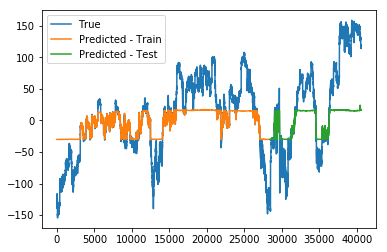

2018-05-05 00:43:11,526 - VOC_TOPICS - INFO - Epoch 10, loss: 13.470.
2018-05-05 00:43:11,526 - VOC_TOPICS - INFO - Epoch 10, loss: 13.470.


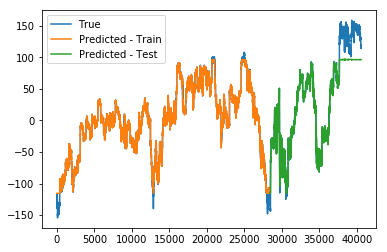

2018-05-05 00:50:12,540 - VOC_TOPICS - INFO - Epoch 20, loss: 5.581.
2018-05-05 00:50:12,540 - VOC_TOPICS - INFO - Epoch 20, loss: 5.581.


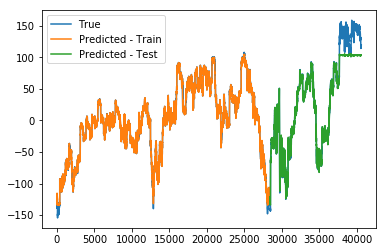

2018-05-05 00:57:16,746 - VOC_TOPICS - INFO - Epoch 30, loss: 4.835.
2018-05-05 00:57:16,746 - VOC_TOPICS - INFO - Epoch 30, loss: 4.835.


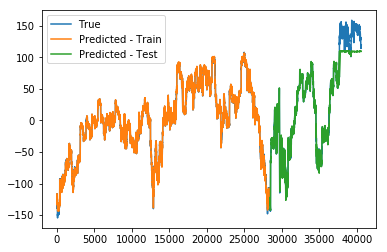

2018-05-05 01:04:11,402 - VOC_TOPICS - INFO - Epoch 40, loss: 4.748.
2018-05-05 01:04:11,402 - VOC_TOPICS - INFO - Epoch 40, loss: 4.748.


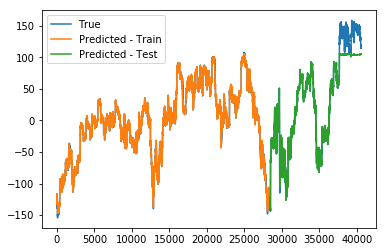

2018-05-05 01:11:07,860 - VOC_TOPICS - INFO - Epoch 50, loss: 4.722.
2018-05-05 01:11:07,860 - VOC_TOPICS - INFO - Epoch 50, loss: 4.722.


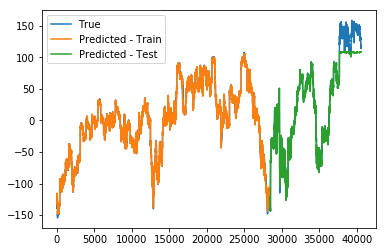

2018-05-05 01:17:59,552 - VOC_TOPICS - INFO - Epoch 60, loss: 4.707.
2018-05-05 01:17:59,552 - VOC_TOPICS - INFO - Epoch 60, loss: 4.707.


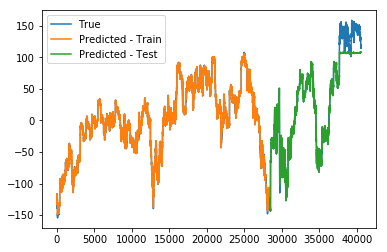

2018-05-05 01:24:51,753 - VOC_TOPICS - INFO - Epoch 70, loss: 4.701.
2018-05-05 01:24:51,753 - VOC_TOPICS - INFO - Epoch 70, loss: 4.701.


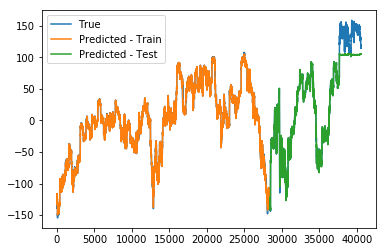

2018-05-05 01:31:45,439 - VOC_TOPICS - INFO - Epoch 80, loss: 4.669.
2018-05-05 01:31:45,439 - VOC_TOPICS - INFO - Epoch 80, loss: 4.669.


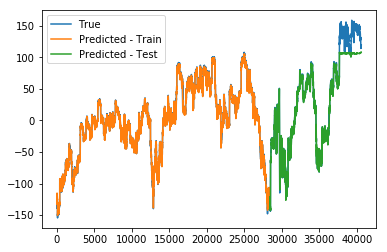

2018-05-05 01:38:38,198 - VOC_TOPICS - INFO - Epoch 90, loss: 4.638.
2018-05-05 01:38:38,198 - VOC_TOPICS - INFO - Epoch 90, loss: 4.638.


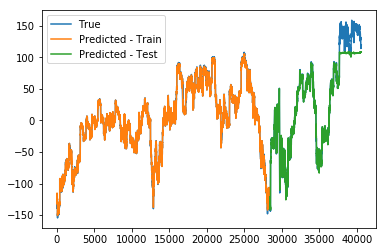

2018-05-05 07:20:48,872 - VOC_TOPICS - INFO - Epoch 100, loss: 4.635.
2018-05-05 07:20:48,872 - VOC_TOPICS - INFO - Epoch 100, loss: 4.635.


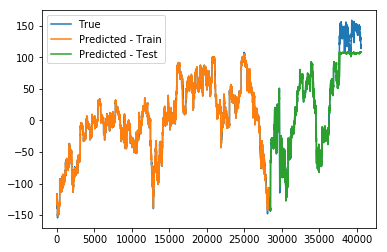

2018-05-05 12:25:57,532 - VOC_TOPICS - INFO - Epoch 110, loss: 4.603.
2018-05-05 12:25:57,532 - VOC_TOPICS - INFO - Epoch 110, loss: 4.603.


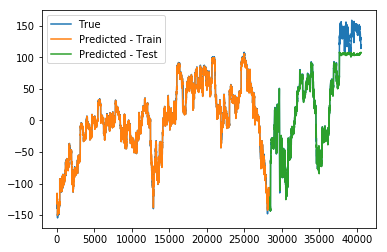

2018-05-05 12:53:19,744 - VOC_TOPICS - INFO - Epoch 120, loss: 4.601.
2018-05-05 12:53:19,744 - VOC_TOPICS - INFO - Epoch 120, loss: 4.601.


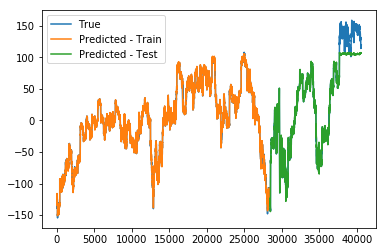

2018-05-05 13:01:26,655 - VOC_TOPICS - INFO - Epoch 130, loss: 4.587.
2018-05-05 13:01:26,655 - VOC_TOPICS - INFO - Epoch 130, loss: 4.587.


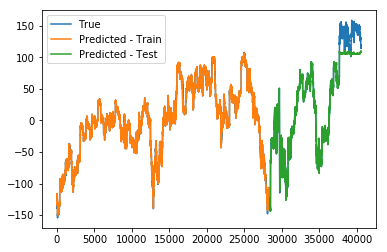

2018-05-05 13:09:19,638 - VOC_TOPICS - INFO - Epoch 140, loss: 4.561.
2018-05-05 13:09:19,638 - VOC_TOPICS - INFO - Epoch 140, loss: 4.561.


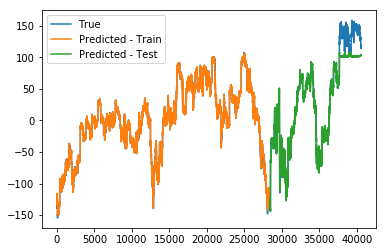

2018-05-05 13:18:03,415 - VOC_TOPICS - INFO - Epoch 150, loss: 4.518.
2018-05-05 13:18:03,415 - VOC_TOPICS - INFO - Epoch 150, loss: 4.518.


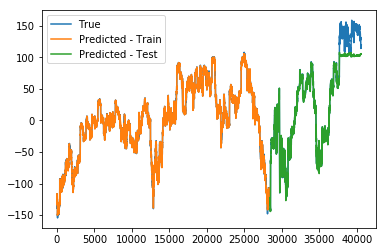

2018-05-05 13:26:27,746 - VOC_TOPICS - INFO - Epoch 160, loss: 4.518.
2018-05-05 13:26:27,746 - VOC_TOPICS - INFO - Epoch 160, loss: 4.518.


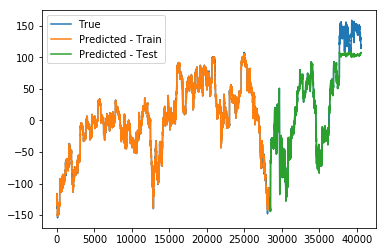

2018-05-05 13:34:38,869 - VOC_TOPICS - INFO - Epoch 170, loss: 4.473.
2018-05-05 13:34:38,869 - VOC_TOPICS - INFO - Epoch 170, loss: 4.473.


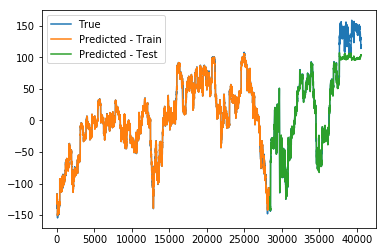

2018-05-05 13:42:54,993 - VOC_TOPICS - INFO - Epoch 180, loss: 4.447.
2018-05-05 13:42:54,993 - VOC_TOPICS - INFO - Epoch 180, loss: 4.447.


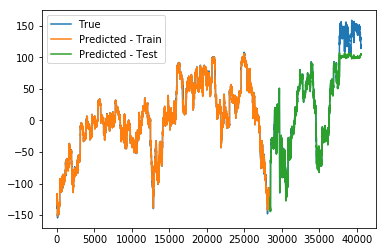

2018-05-05 13:51:27,719 - VOC_TOPICS - INFO - Epoch 190, loss: 4.412.
2018-05-05 13:51:27,719 - VOC_TOPICS - INFO - Epoch 190, loss: 4.412.


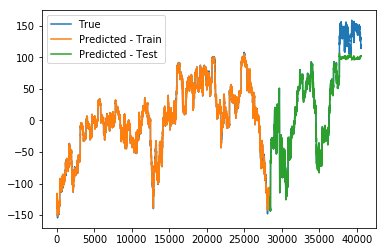

2018-05-05 13:59:32,150 - VOC_TOPICS - INFO - Epoch 200, loss: 4.415.
2018-05-05 13:59:32,150 - VOC_TOPICS - INFO - Epoch 200, loss: 4.415.


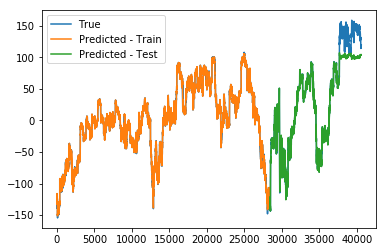

2018-05-05 14:08:25,762 - VOC_TOPICS - INFO - Epoch 210, loss: 4.386.
2018-05-05 14:08:25,762 - VOC_TOPICS - INFO - Epoch 210, loss: 4.386.


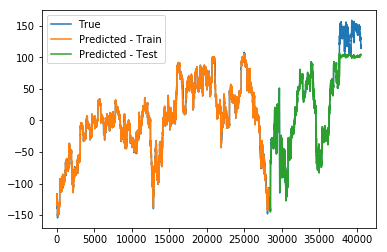

2018-05-05 14:17:26,016 - VOC_TOPICS - INFO - Epoch 220, loss: 4.393.
2018-05-05 14:17:26,016 - VOC_TOPICS - INFO - Epoch 220, loss: 4.393.


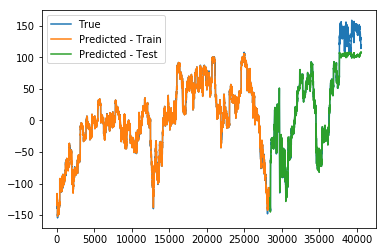

2018-05-05 14:25:39,517 - VOC_TOPICS - INFO - Epoch 230, loss: 4.336.
2018-05-05 14:25:39,517 - VOC_TOPICS - INFO - Epoch 230, loss: 4.336.


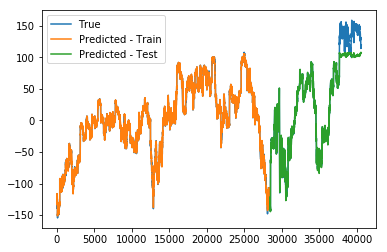

2018-05-05 14:34:16,202 - VOC_TOPICS - INFO - Epoch 240, loss: 4.326.
2018-05-05 14:34:16,202 - VOC_TOPICS - INFO - Epoch 240, loss: 4.326.


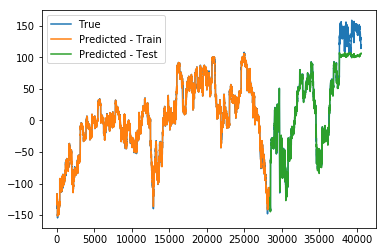

2018-05-05 14:42:16,153 - VOC_TOPICS - INFO - Epoch 250, loss: 4.280.
2018-05-05 14:42:16,153 - VOC_TOPICS - INFO - Epoch 250, loss: 4.280.


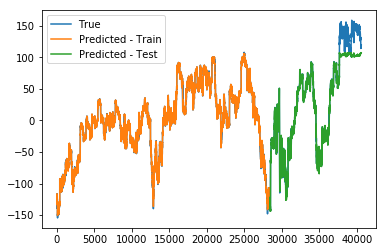

2018-05-05 14:50:43,974 - VOC_TOPICS - INFO - Epoch 260, loss: 4.300.
2018-05-05 14:50:43,974 - VOC_TOPICS - INFO - Epoch 260, loss: 4.300.


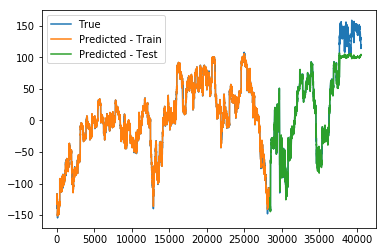

2018-05-05 14:59:09,945 - VOC_TOPICS - INFO - Epoch 270, loss: 4.254.
2018-05-05 14:59:09,945 - VOC_TOPICS - INFO - Epoch 270, loss: 4.254.


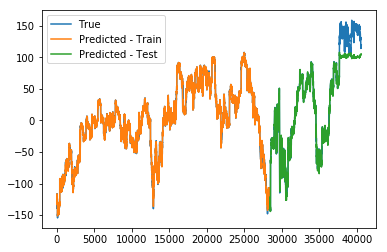

2018-05-05 15:07:52,947 - VOC_TOPICS - INFO - Epoch 280, loss: 4.241.
2018-05-05 15:07:52,947 - VOC_TOPICS - INFO - Epoch 280, loss: 4.241.


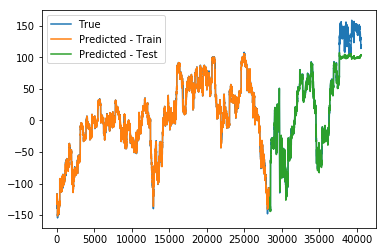

2018-05-05 15:16:41,239 - VOC_TOPICS - INFO - Epoch 290, loss: 4.205.
2018-05-05 15:16:41,239 - VOC_TOPICS - INFO - Epoch 290, loss: 4.205.


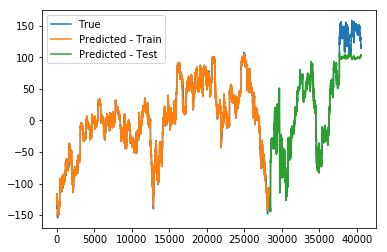

2018-05-05 15:25:25,044 - VOC_TOPICS - INFO - Epoch 300, loss: 4.202.
2018-05-05 15:25:25,044 - VOC_TOPICS - INFO - Epoch 300, loss: 4.202.


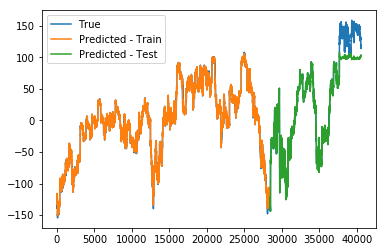

2018-05-05 15:33:47,529 - VOC_TOPICS - INFO - Epoch 310, loss: 4.190.
2018-05-05 15:33:47,529 - VOC_TOPICS - INFO - Epoch 310, loss: 4.190.


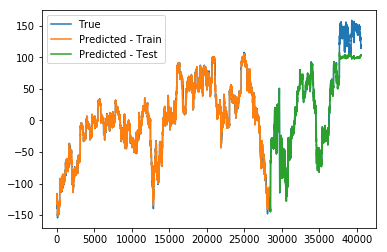

2018-05-05 15:42:29,142 - VOC_TOPICS - INFO - Epoch 320, loss: 4.159.
2018-05-05 15:42:29,142 - VOC_TOPICS - INFO - Epoch 320, loss: 4.159.


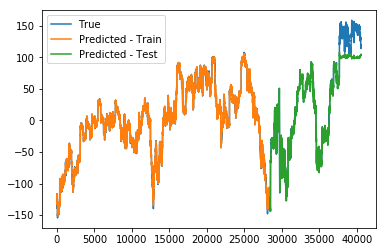

2018-05-05 15:51:55,308 - VOC_TOPICS - INFO - Epoch 330, loss: 4.125.
2018-05-05 15:51:55,308 - VOC_TOPICS - INFO - Epoch 330, loss: 4.125.


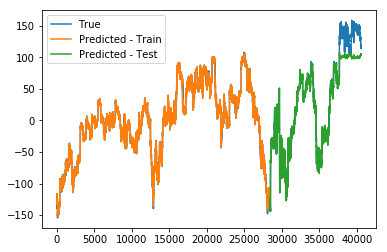

2018-05-05 16:00:31,579 - VOC_TOPICS - INFO - Epoch 340, loss: 4.127.
2018-05-05 16:00:31,579 - VOC_TOPICS - INFO - Epoch 340, loss: 4.127.


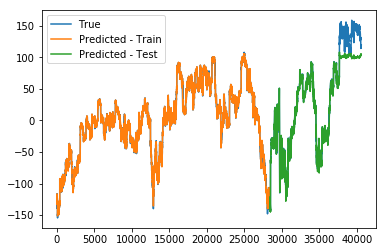

2018-05-05 16:09:08,508 - VOC_TOPICS - INFO - Epoch 350, loss: 4.114.
2018-05-05 16:09:08,508 - VOC_TOPICS - INFO - Epoch 350, loss: 4.114.


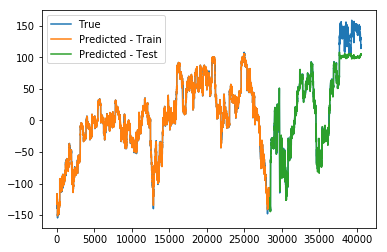

2018-05-05 16:17:11,479 - VOC_TOPICS - INFO - Epoch 360, loss: 4.081.
2018-05-05 16:17:11,479 - VOC_TOPICS - INFO - Epoch 360, loss: 4.081.


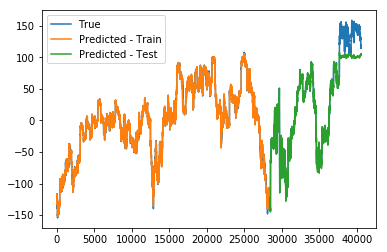

2018-05-05 16:26:25,717 - VOC_TOPICS - INFO - Epoch 370, loss: 4.058.
2018-05-05 16:26:25,717 - VOC_TOPICS - INFO - Epoch 370, loss: 4.058.


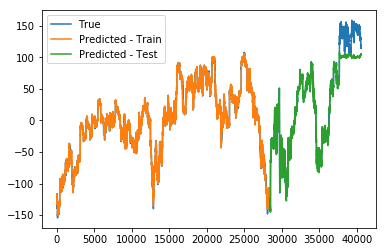

2018-05-05 16:35:21,348 - VOC_TOPICS - INFO - Epoch 380, loss: 4.040.
2018-05-05 16:35:21,348 - VOC_TOPICS - INFO - Epoch 380, loss: 4.040.


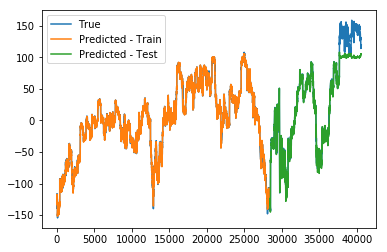

2018-05-05 16:43:52,792 - VOC_TOPICS - INFO - Epoch 390, loss: 4.036.
2018-05-05 16:43:52,792 - VOC_TOPICS - INFO - Epoch 390, loss: 4.036.


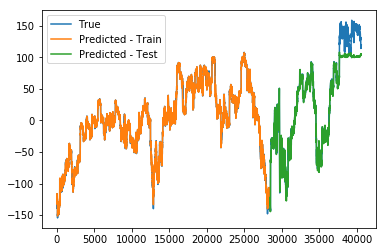

2018-05-05 16:53:22,964 - VOC_TOPICS - INFO - Epoch 400, loss: 4.013.
2018-05-05 16:53:22,964 - VOC_TOPICS - INFO - Epoch 400, loss: 4.013.


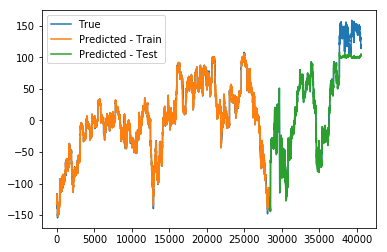

2018-05-05 17:02:06,753 - VOC_TOPICS - INFO - Epoch 410, loss: 3.971.
2018-05-05 17:02:06,753 - VOC_TOPICS - INFO - Epoch 410, loss: 3.971.


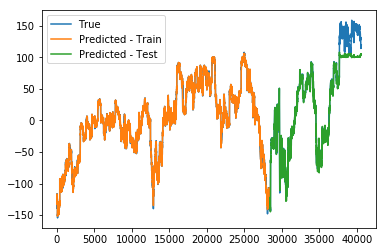

2018-05-05 17:11:28,988 - VOC_TOPICS - INFO - Epoch 420, loss: 3.977.
2018-05-05 17:11:28,988 - VOC_TOPICS - INFO - Epoch 420, loss: 3.977.


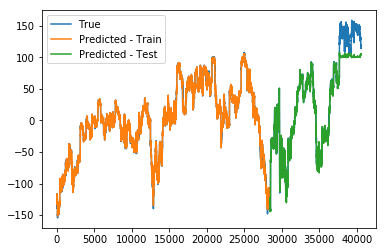

2018-05-05 17:20:54,240 - VOC_TOPICS - INFO - Epoch 430, loss: 3.955.
2018-05-05 17:20:54,240 - VOC_TOPICS - INFO - Epoch 430, loss: 3.955.


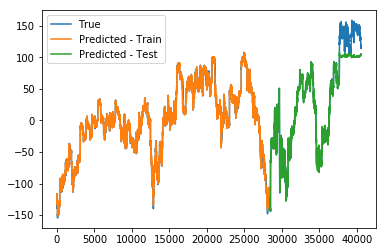

2018-05-05 17:30:19,457 - VOC_TOPICS - INFO - Epoch 440, loss: 3.948.
2018-05-05 17:30:19,457 - VOC_TOPICS - INFO - Epoch 440, loss: 3.948.


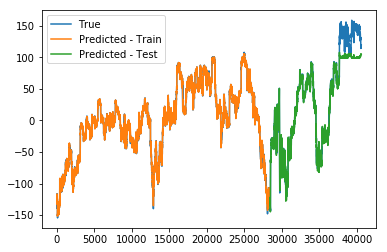

2018-05-05 17:41:00,199 - VOC_TOPICS - INFO - Epoch 450, loss: 3.916.
2018-05-05 17:41:00,199 - VOC_TOPICS - INFO - Epoch 450, loss: 3.916.


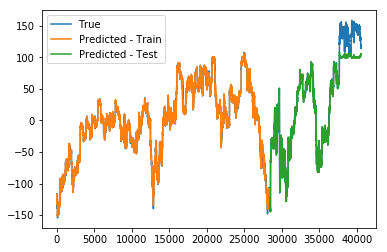

2018-05-05 19:50:01,174 - VOC_TOPICS - INFO - Epoch 460, loss: 3.911.
2018-05-05 19:50:01,174 - VOC_TOPICS - INFO - Epoch 460, loss: 3.911.


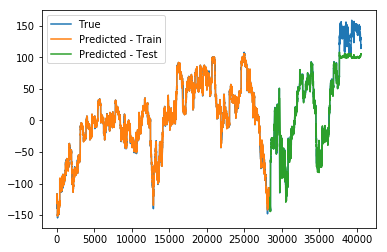

2018-05-05 19:58:34,086 - VOC_TOPICS - INFO - Epoch 470, loss: 3.910.
2018-05-05 19:58:34,086 - VOC_TOPICS - INFO - Epoch 470, loss: 3.910.


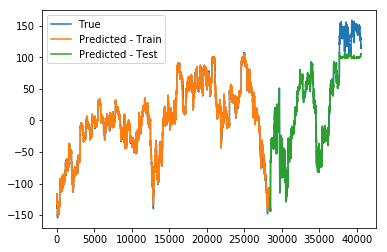

2018-05-05 20:07:52,309 - VOC_TOPICS - INFO - Epoch 480, loss: 3.869.
2018-05-05 20:07:52,309 - VOC_TOPICS - INFO - Epoch 480, loss: 3.869.


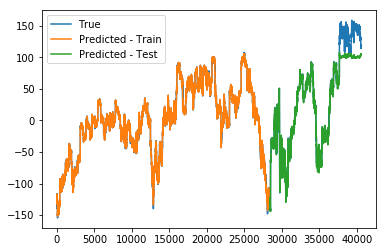

2018-05-05 20:17:00,606 - VOC_TOPICS - INFO - Epoch 490, loss: 3.880.
2018-05-05 20:17:00,606 - VOC_TOPICS - INFO - Epoch 490, loss: 3.880.


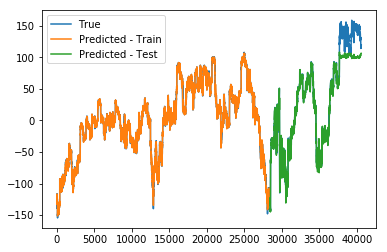

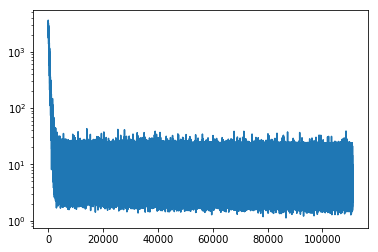

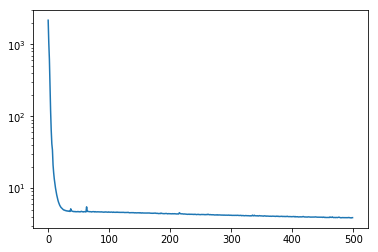

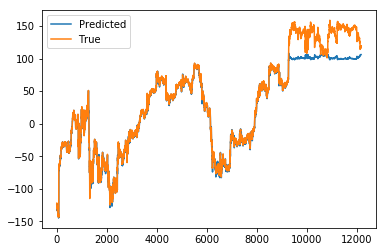

In [63]:
io_dir = 'nasdaq'

model = da_rnn(file_data = '{}/data/nasdaq100_padding.csv'.format(io_dir), logger = logger, parallel = False,
              learning_rate = .001, debug=False)

model.train(n_epochs = 500)

y_pred = model.predict()

plt.figure()
plt.semilogy(range(len(model.iter_losses)), model.iter_losses)
plt.show()

plt.figure()
plt.semilogy(range(len(model.epoch_losses)), model.epoch_losses)
plt.show()

plt.figure()
plt.plot(y_pred, label = 'Predicted')
plt.plot(model.y[model.train_size:], label = "True")
plt.legend(loc = 'upper left')
plt.show()

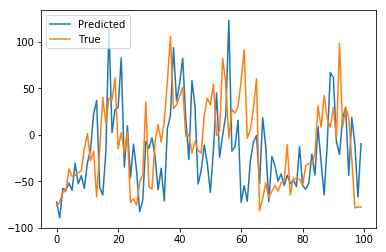

In [115]:
plt.figure()
plt.plot(y_pred[:100], label = 'Predicted')
plt.plot(model.y[model.train_size:model.train_size + 100], label = "True")
plt.legend(loc = 'upper left')
plt.show()

2018-05-07 00:26:56,421 - VOC_TOPICS - INFO - Shape of data: (5000, 21).
Missing in data: 0.
2018-05-07 00:26:56,421 - VOC_TOPICS - INFO - Shape of data: (5000, 21).
Missing in data: 0.
2018-05-07 00:26:56,432 - VOC_TOPICS - INFO - Training size: 3500.
2018-05-07 00:26:56,432 - VOC_TOPICS - INFO - Training size: 3500.
2018-05-07 00:26:56,435 - VOC_TOPICS - INFO - Iterations per epoch: 27.344 ~ 28.
2018-05-07 00:26:56,435 - VOC_TOPICS - INFO - Iterations per epoch: 27.344 ~ 28.


       pm25         t2m         d2m       u10       v10            sp  \
0      51.0  270.487368  258.980250  2.507680 -0.658156  97997.728951   
1      23.0  283.838611  258.241520  3.154037 -0.050984  98048.881796   
2      66.0  273.009328  261.723400  1.842218 -1.248453  98354.616140   
3     127.0  270.101179  262.794066  0.369782 -1.550008  98568.984998   
4     119.0  268.554291  262.665035  0.382165 -1.082520  98565.141143   
5     108.0  281.021141  262.805886  1.372043  0.864305  98220.376883   
6     168.0  274.254307  263.928755  1.946937 -1.228454  98300.802165   
7     122.0  273.074404  262.622681  1.463319 -2.884348  98494.769021   
8      30.0  270.140652  260.127744  0.696676 -2.797163  98825.044903   
9      16.0  280.057803  259.841117  0.031922 -1.408137  98795.476785   
10     57.0  272.718087  261.033919  0.904699  2.489575  99022.559934   
11     76.0  268.415605  263.193965  0.498912  2.338641  99041.483529   
12     78.0  266.483595  263.732746 -0.057585  2.57

/Users/luoweimeng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/luoweimeng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:82: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/luoweimeng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
2018-05-07 00:26:59,438 - VOC_TOPICS - INFO - Epoch 0, loss: 7093.975.
2018-05-07 00:26:59,438 - VOC_TOPICS - INFO - Epoch 0, loss: 7093.975.


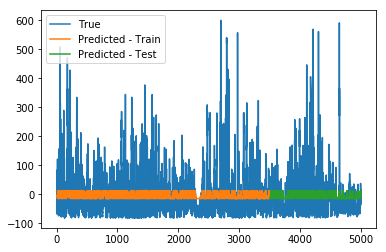

2018-05-07 00:27:30,541 - VOC_TOPICS - INFO - Epoch 10, loss: 4808.803.
2018-05-07 00:27:30,541 - VOC_TOPICS - INFO - Epoch 10, loss: 4808.803.


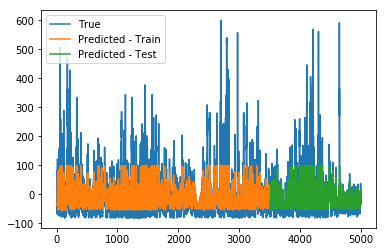

2018-05-07 00:27:59,311 - VOC_TOPICS - INFO - Epoch 20, loss: 4531.299.
2018-05-07 00:27:59,311 - VOC_TOPICS - INFO - Epoch 20, loss: 4531.299.


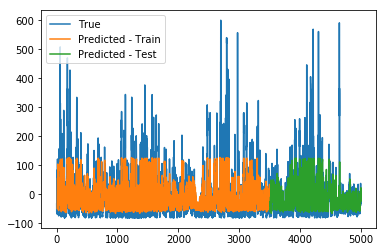

2018-05-07 00:28:29,664 - VOC_TOPICS - INFO - Epoch 30, loss: 4380.849.
2018-05-07 00:28:29,664 - VOC_TOPICS - INFO - Epoch 30, loss: 4380.849.


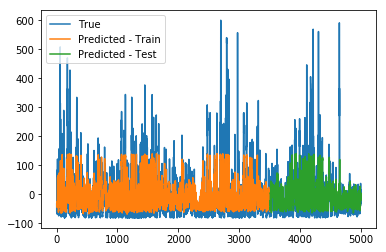

2018-05-07 00:28:57,345 - VOC_TOPICS - INFO - Epoch 40, loss: 4129.177.
2018-05-07 00:28:57,345 - VOC_TOPICS - INFO - Epoch 40, loss: 4129.177.


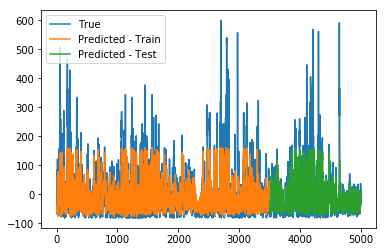

2018-05-07 00:29:24,183 - VOC_TOPICS - INFO - Epoch 50, loss: 3819.060.
2018-05-07 00:29:24,183 - VOC_TOPICS - INFO - Epoch 50, loss: 3819.060.


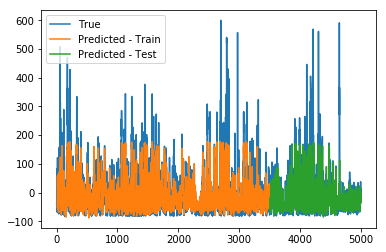

2018-05-07 00:29:52,290 - VOC_TOPICS - INFO - Epoch 60, loss: 3335.116.
2018-05-07 00:29:52,290 - VOC_TOPICS - INFO - Epoch 60, loss: 3335.116.


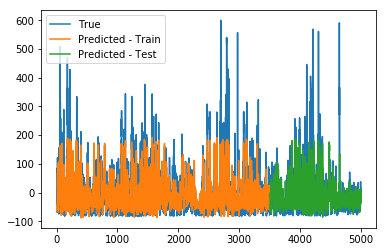

2018-05-07 00:30:20,519 - VOC_TOPICS - INFO - Epoch 70, loss: 3312.677.
2018-05-07 00:30:20,519 - VOC_TOPICS - INFO - Epoch 70, loss: 3312.677.


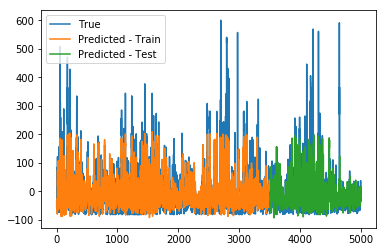

2018-05-07 00:30:47,477 - VOC_TOPICS - INFO - Epoch 80, loss: 3098.247.
2018-05-07 00:30:47,477 - VOC_TOPICS - INFO - Epoch 80, loss: 3098.247.


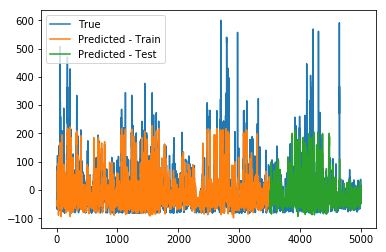

2018-05-07 00:31:15,747 - VOC_TOPICS - INFO - Epoch 90, loss: 2742.316.
2018-05-07 00:31:15,747 - VOC_TOPICS - INFO - Epoch 90, loss: 2742.316.


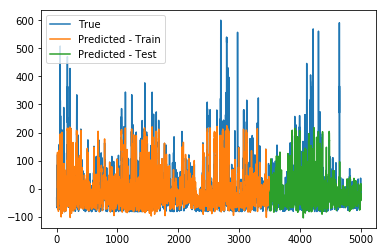

2018-05-07 00:31:43,981 - VOC_TOPICS - INFO - Epoch 100, loss: 2705.527.
2018-05-07 00:31:43,981 - VOC_TOPICS - INFO - Epoch 100, loss: 2705.527.


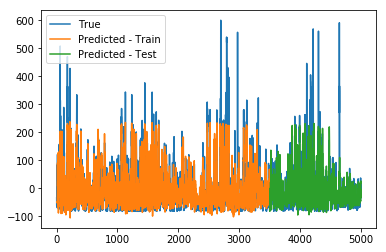

2018-05-07 00:32:11,531 - VOC_TOPICS - INFO - Epoch 110, loss: 2498.075.
2018-05-07 00:32:11,531 - VOC_TOPICS - INFO - Epoch 110, loss: 2498.075.


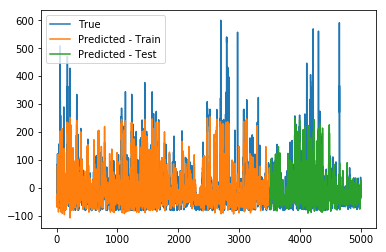

2018-05-07 00:32:43,466 - VOC_TOPICS - INFO - Epoch 120, loss: 2317.131.
2018-05-07 00:32:43,466 - VOC_TOPICS - INFO - Epoch 120, loss: 2317.131.


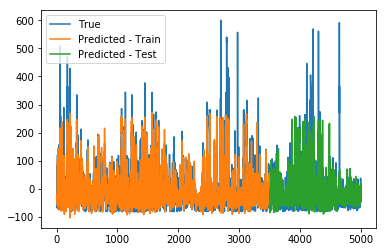

2018-05-07 00:33:15,038 - VOC_TOPICS - INFO - Epoch 130, loss: 2181.736.
2018-05-07 00:33:15,038 - VOC_TOPICS - INFO - Epoch 130, loss: 2181.736.


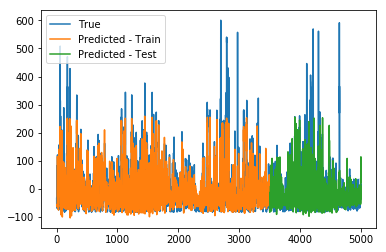

2018-05-07 00:33:44,646 - VOC_TOPICS - INFO - Epoch 140, loss: 1993.305.
2018-05-07 00:33:44,646 - VOC_TOPICS - INFO - Epoch 140, loss: 1993.305.


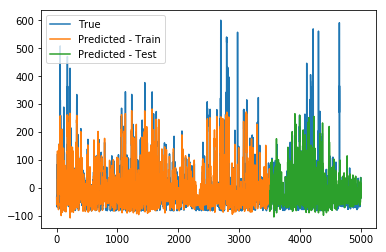

2018-05-07 00:34:14,309 - VOC_TOPICS - INFO - Epoch 150, loss: 2078.902.
2018-05-07 00:34:14,309 - VOC_TOPICS - INFO - Epoch 150, loss: 2078.902.


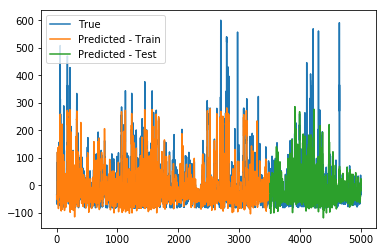

2018-05-07 00:34:43,622 - VOC_TOPICS - INFO - Epoch 160, loss: 2416.639.
2018-05-07 00:34:43,622 - VOC_TOPICS - INFO - Epoch 160, loss: 2416.639.


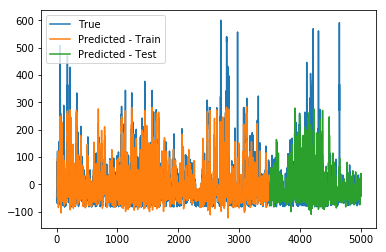

2018-05-07 00:35:13,322 - VOC_TOPICS - INFO - Epoch 170, loss: 1740.360.
2018-05-07 00:35:13,322 - VOC_TOPICS - INFO - Epoch 170, loss: 1740.360.


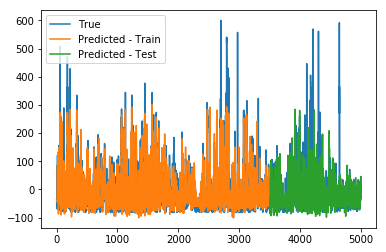

2018-05-07 00:35:40,845 - VOC_TOPICS - INFO - Epoch 180, loss: 1796.749.
2018-05-07 00:35:40,845 - VOC_TOPICS - INFO - Epoch 180, loss: 1796.749.


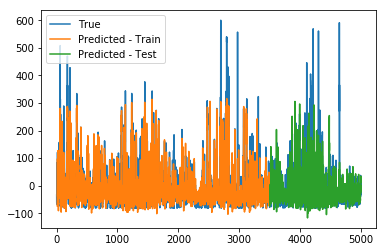

2018-05-07 00:36:10,181 - VOC_TOPICS - INFO - Epoch 190, loss: 1587.531.
2018-05-07 00:36:10,181 - VOC_TOPICS - INFO - Epoch 190, loss: 1587.531.


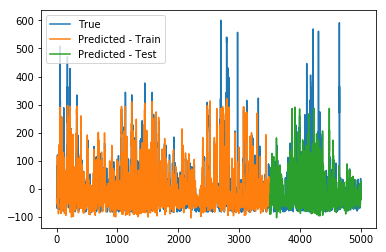

2018-05-07 00:36:40,524 - VOC_TOPICS - INFO - Epoch 200, loss: 1619.096.
2018-05-07 00:36:40,524 - VOC_TOPICS - INFO - Epoch 200, loss: 1619.096.


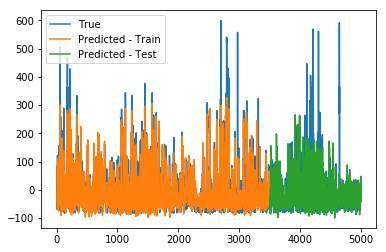

2018-05-07 00:37:08,343 - VOC_TOPICS - INFO - Epoch 210, loss: 1605.439.
2018-05-07 00:37:08,343 - VOC_TOPICS - INFO - Epoch 210, loss: 1605.439.


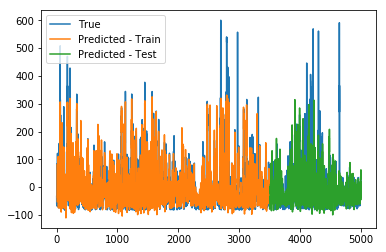

2018-05-07 00:37:37,978 - VOC_TOPICS - INFO - Epoch 220, loss: 2112.232.
2018-05-07 00:37:37,978 - VOC_TOPICS - INFO - Epoch 220, loss: 2112.232.


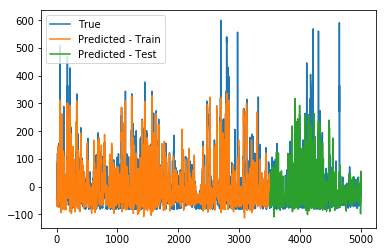

2018-05-07 00:38:05,828 - VOC_TOPICS - INFO - Epoch 230, loss: 1652.425.
2018-05-07 00:38:05,828 - VOC_TOPICS - INFO - Epoch 230, loss: 1652.425.


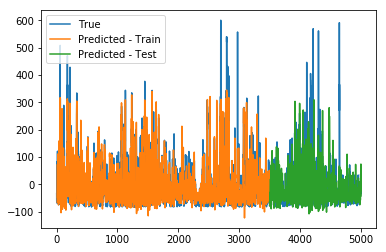

2018-05-07 00:38:36,653 - VOC_TOPICS - INFO - Epoch 240, loss: 1566.633.
2018-05-07 00:38:36,653 - VOC_TOPICS - INFO - Epoch 240, loss: 1566.633.


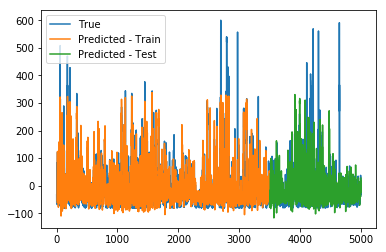

2018-05-07 00:39:04,748 - VOC_TOPICS - INFO - Epoch 250, loss: 1400.163.
2018-05-07 00:39:04,748 - VOC_TOPICS - INFO - Epoch 250, loss: 1400.163.


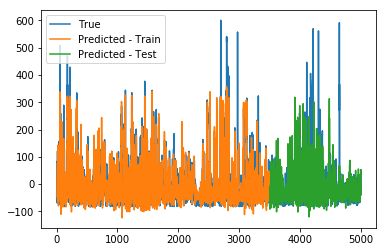

2018-05-07 00:39:32,402 - VOC_TOPICS - INFO - Epoch 260, loss: 1572.185.
2018-05-07 00:39:32,402 - VOC_TOPICS - INFO - Epoch 260, loss: 1572.185.


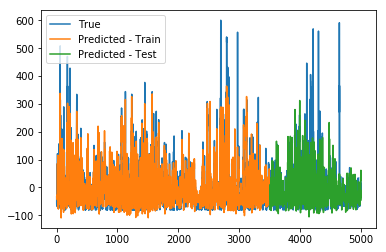

2018-05-07 00:39:59,382 - VOC_TOPICS - INFO - Epoch 270, loss: 1652.859.
2018-05-07 00:39:59,382 - VOC_TOPICS - INFO - Epoch 270, loss: 1652.859.


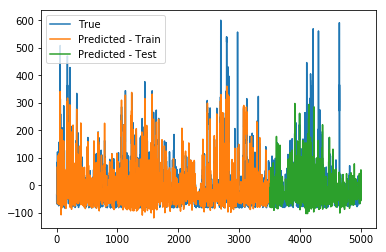

2018-05-07 00:40:26,428 - VOC_TOPICS - INFO - Epoch 280, loss: 1196.576.
2018-05-07 00:40:26,428 - VOC_TOPICS - INFO - Epoch 280, loss: 1196.576.


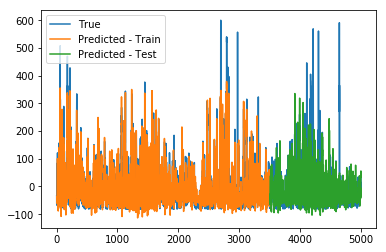

2018-05-07 00:40:54,512 - VOC_TOPICS - INFO - Epoch 290, loss: 1231.970.
2018-05-07 00:40:54,512 - VOC_TOPICS - INFO - Epoch 290, loss: 1231.970.


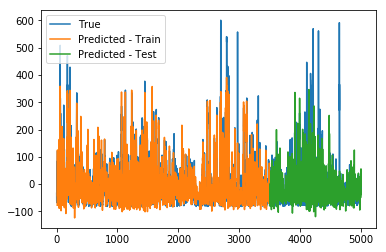

2018-05-07 00:41:21,550 - VOC_TOPICS - INFO - Epoch 300, loss: 1386.813.
2018-05-07 00:41:21,550 - VOC_TOPICS - INFO - Epoch 300, loss: 1386.813.


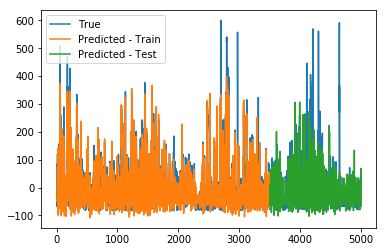

2018-05-07 00:42:06,030 - VOC_TOPICS - INFO - Epoch 310, loss: 1085.528.
2018-05-07 00:42:06,030 - VOC_TOPICS - INFO - Epoch 310, loss: 1085.528.


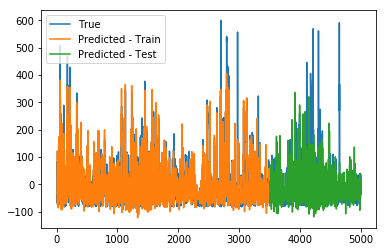

2018-05-07 00:42:33,819 - VOC_TOPICS - INFO - Epoch 320, loss: 1074.512.
2018-05-07 00:42:33,819 - VOC_TOPICS - INFO - Epoch 320, loss: 1074.512.


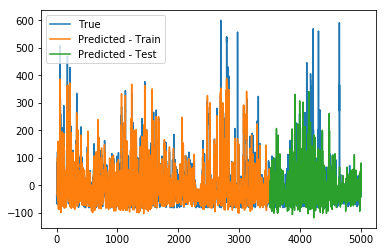

2018-05-07 00:42:59,047 - VOC_TOPICS - INFO - Epoch 330, loss: 1319.993.
2018-05-07 00:42:59,047 - VOC_TOPICS - INFO - Epoch 330, loss: 1319.993.


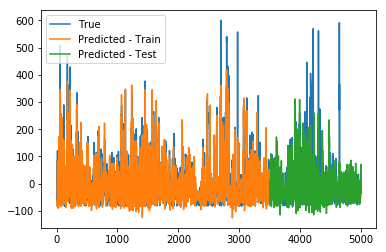

2018-05-07 00:43:24,339 - VOC_TOPICS - INFO - Epoch 340, loss: 2015.175.
2018-05-07 00:43:24,339 - VOC_TOPICS - INFO - Epoch 340, loss: 2015.175.


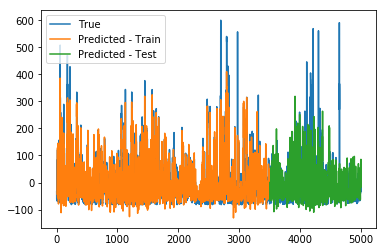

2018-05-07 00:43:49,569 - VOC_TOPICS - INFO - Epoch 350, loss: 1510.944.
2018-05-07 00:43:49,569 - VOC_TOPICS - INFO - Epoch 350, loss: 1510.944.


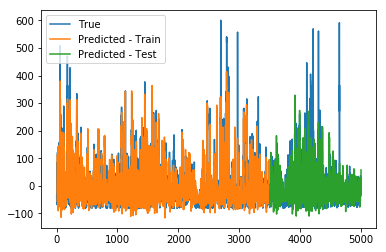

2018-05-07 00:44:14,739 - VOC_TOPICS - INFO - Epoch 360, loss: 2008.301.
2018-05-07 00:44:14,739 - VOC_TOPICS - INFO - Epoch 360, loss: 2008.301.


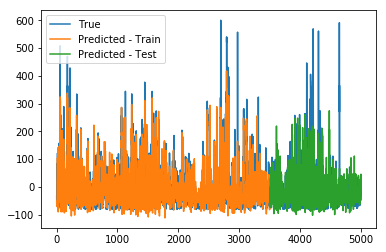

2018-05-07 00:44:40,063 - VOC_TOPICS - INFO - Epoch 370, loss: 1291.231.
2018-05-07 00:44:40,063 - VOC_TOPICS - INFO - Epoch 370, loss: 1291.231.


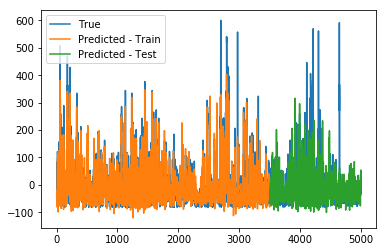

2018-05-07 00:45:07,001 - VOC_TOPICS - INFO - Epoch 380, loss: 1148.712.
2018-05-07 00:45:07,001 - VOC_TOPICS - INFO - Epoch 380, loss: 1148.712.


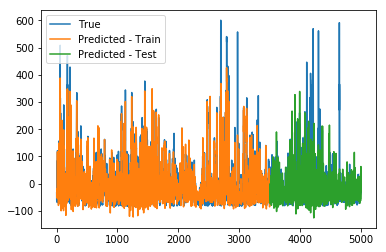

2018-05-07 00:45:33,499 - VOC_TOPICS - INFO - Epoch 390, loss: 1153.397.
2018-05-07 00:45:33,499 - VOC_TOPICS - INFO - Epoch 390, loss: 1153.397.


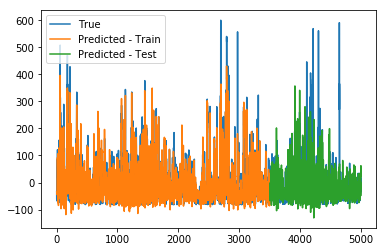

2018-05-07 00:45:58,723 - VOC_TOPICS - INFO - Epoch 400, loss: 1856.340.
2018-05-07 00:45:58,723 - VOC_TOPICS - INFO - Epoch 400, loss: 1856.340.


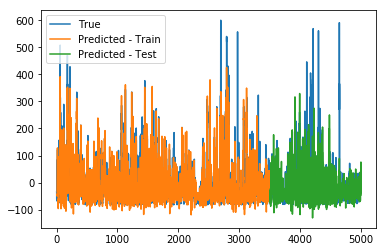

2018-05-07 00:46:23,806 - VOC_TOPICS - INFO - Epoch 410, loss: 1288.394.
2018-05-07 00:46:23,806 - VOC_TOPICS - INFO - Epoch 410, loss: 1288.394.


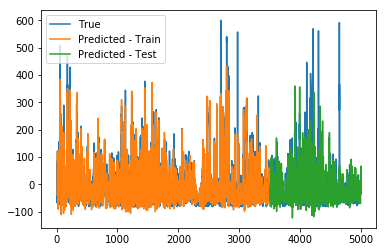

2018-05-07 00:46:49,890 - VOC_TOPICS - INFO - Epoch 420, loss: 1040.687.
2018-05-07 00:46:49,890 - VOC_TOPICS - INFO - Epoch 420, loss: 1040.687.


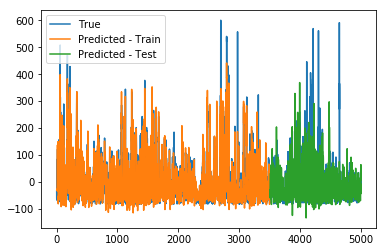

2018-05-07 00:47:15,023 - VOC_TOPICS - INFO - Epoch 430, loss: 1117.051.
2018-05-07 00:47:15,023 - VOC_TOPICS - INFO - Epoch 430, loss: 1117.051.


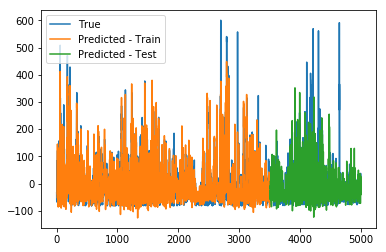

2018-05-07 00:47:40,797 - VOC_TOPICS - INFO - Epoch 440, loss: 816.233.
2018-05-07 00:47:40,797 - VOC_TOPICS - INFO - Epoch 440, loss: 816.233.


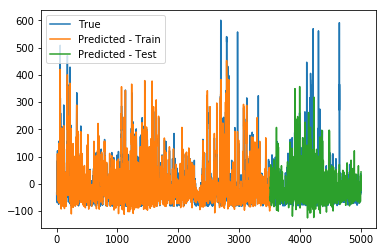

2018-05-07 00:48:05,969 - VOC_TOPICS - INFO - Epoch 450, loss: 823.316.
2018-05-07 00:48:05,969 - VOC_TOPICS - INFO - Epoch 450, loss: 823.316.


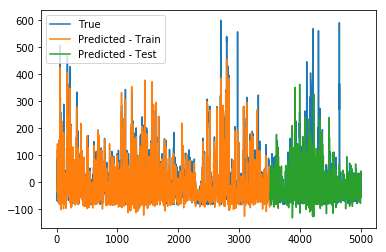

2018-05-07 00:48:31,166 - VOC_TOPICS - INFO - Epoch 460, loss: 1173.574.
2018-05-07 00:48:31,166 - VOC_TOPICS - INFO - Epoch 460, loss: 1173.574.


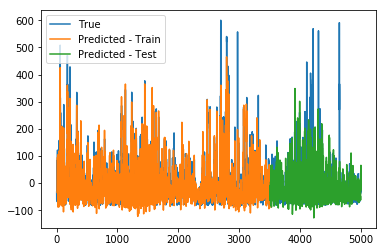

2018-05-07 00:48:56,451 - VOC_TOPICS - INFO - Epoch 470, loss: 1475.628.
2018-05-07 00:48:56,451 - VOC_TOPICS - INFO - Epoch 470, loss: 1475.628.


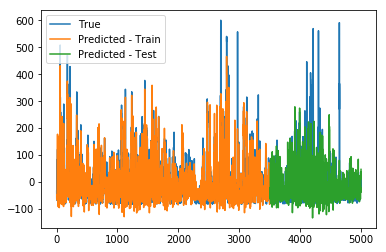

2018-05-07 00:49:21,656 - VOC_TOPICS - INFO - Epoch 480, loss: 1285.778.
2018-05-07 00:49:21,656 - VOC_TOPICS - INFO - Epoch 480, loss: 1285.778.


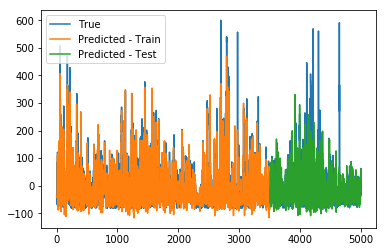

2018-05-07 00:49:46,688 - VOC_TOPICS - INFO - Epoch 490, loss: 1195.044.
2018-05-07 00:49:46,688 - VOC_TOPICS - INFO - Epoch 490, loss: 1195.044.


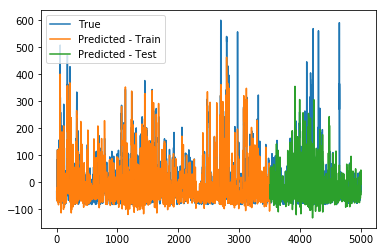

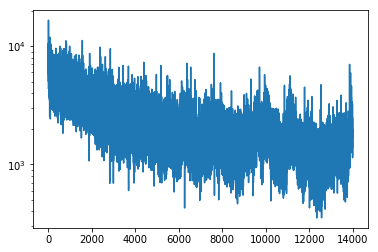

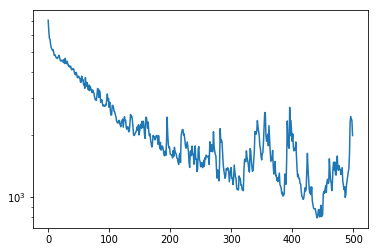

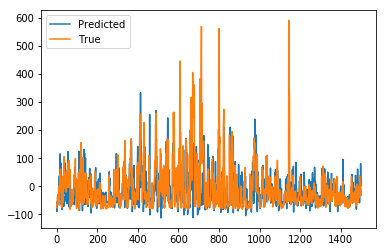

In [111]:
io_dir = '..'

model = da_rnn(file_data = '{}/raw_data_new.csv'.format(io_dir), logger = logger, parallel = False,
              learning_rate = .01, data_type='pm25', debug=False)

model.train(n_epochs = 500)

y_pred = model.predict()

plt.figure()
plt.semilogy(range(len(model.iter_losses)), model.iter_losses)
plt.show()

plt.figure()
plt.semilogy(range(len(model.epoch_losses)), model.epoch_losses)
plt.show()

plt.figure()
plt.plot(y_pred, label = 'Predicted')
plt.plot(model.y[model.train_size:], label = "True")
plt.legend(loc = 'upper left')
plt.show()

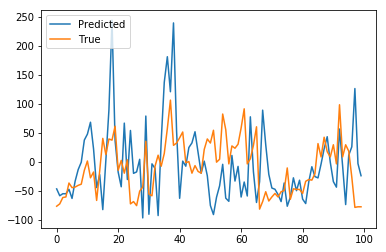

In [110]:
plt.figure()
plt.plot(y_pred[:100], label = 'Predicted')
plt.plot(model.y[model.train_size:model.train_size+100], label = "True")
plt.legend(loc = 'upper left')
plt.show()

In [112]:
from sklearn.metrics import mean_squared_error
import math

In [113]:
math.sqrt(mean_squared_error(y_pred, model.y[model.train_size:]))

83.24053188828458

In [104]:
model.y[model.train_size:].shape

(1500,)

In [103]:
y_pred.shape

(1500,)